The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


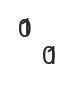

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn
import torch.nn.functional as F
import glob
# Here you import other functions and classes
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import encode_batch, AA_KEYS, BL62_VALUES, BL62FREQ_VALUES, BL50, BL50_VALUES
from src.models import NNAlignEFSinglePass, NNAlignEFTwoStage
from src.datasets import NNAlignDataset
from sklearn.metrics import roc_auc_score, roc_curve


In [5]:
no_struct = pd.concat([pd.read_csv(x)[['sequence','target','HLA','fold','protein_id','start_position','end_position','len','pred','core_start_index','label','motif']] for x in glob.glob('../output/2501XX_MeanStructureEval/*False*/*valid*.csv')])
add_struct = pd.concat([pd.read_csv(x)[['sequence','target','HLA','fold','protein_id','start_position','end_position','len','pred','core_start_index','label','motif']] for x in glob.glob('../output/2501XX_MeanStructureEval/*True*/*valid*.csv')])


In [6]:
from sklearn.metrics import roc_auc_score, roc_curve
for f in sorted(no_struct.fold.unique()):
    print(f'Fold {f}')
    print('no_struct', roc_auc_score(no_struct.query('fold==@f')['target'], no_struct.query('fold==@f')['pred']))
    print('add_struct', roc_auc_score(add_struct.query('fold==@f')['target'], add_struct.query('fold==@f')['pred']))

Fold 0
no_struct 0.985631448746444
add_struct 0.982329236757719
Fold 1
no_struct 0.9849671399722828
add_struct 0.9762495860730451
Fold 2
no_struct 0.9843784590160631
add_struct 0.9766738068590812
Fold 3
no_struct 0.9851592935779733
add_struct 0.9794736020047982
Fold 4
no_struct 0.9862772491168683
add_struct 0.9852317894875189


Text(0.5, 1.0, 'Adding mean structure comparison\nValidation partition AUC (5 partitions merged)')

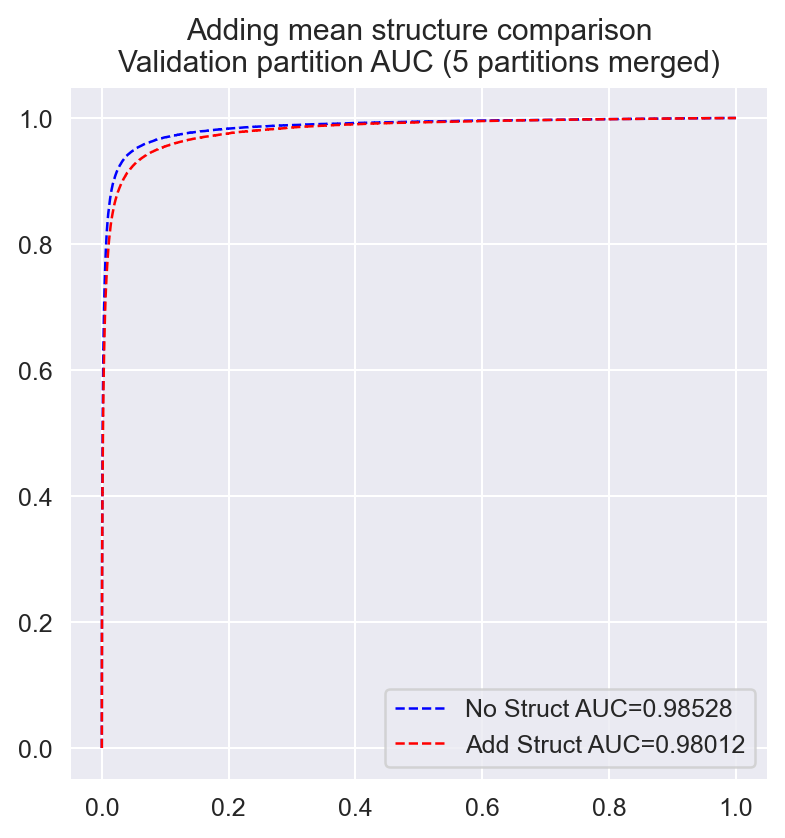

In [7]:
f,a = plt.subplots(1,1, figsize=(5,5))
fpr, tpr, _ = roc_curve(no_struct['target'], no_struct['pred'])
auc = roc_auc_score(no_struct['target'], no_struct['pred'])
a.plot(fpr, tpr, c='b', lw=1, ls='--', label=f'No Struct AUC={auc:.5f}')
fpr, tpr, _ = roc_curve(add_struct['target'], add_struct['pred'])
auc = roc_auc_score(add_struct['target'], add_struct['pred'])
a.plot(fpr, tpr, c='r', lw=1, ls='--', label=f'Add Struct AUC={auc:.5f}')
a.legend()
a.set_title('Adding mean structure comparison\nValidation partition AUC (5 partitions merged)')

In [100]:
add_struct['class'] = add_struct['HLA'].apply(lambda x: x[:5])
no_struct['class'] = no_struct['HLA'].apply(lambda x: x[:5])

In [101]:
add_struct.groupby(['class']).apply(lambda x: roc_auc_score(x['target'].astype(int), x['pred']))

class
HLA-A    0.970997
HLA-B    0.981200
HLA-C    0.978694
dtype: float64

In [103]:
no_struct.groupby(['class']).apply(lambda x: roc_auc_score(x['target'].astype(int), x['pred']))

class
HLA-A    0.979300
HLA-B    0.986941
HLA-C    0.981366
dtype: float64

# investigating

In [8]:
no = pd.concat([pd.read_csv(x) for x in glob.glob('../output/2501XX_MeanStructureEval/*False*/*valid*.csv')])
add = pd.concat([pd.read_csv(x) for x in glob.glob('../output/2501XX_MeanStructureEval/*True*/*valid*.csv')])

In [10]:
def get_mean_struct(df, col):
    df[f'mean_{col}'] = df[col].apply(lambda x: np.mean([float(z) for z in x.split(',')]))
    return df.drop(columns=[col])

def do_all_struct(df, cols):
    for c in cols:
        df = get_mean_struct(df, c)
    return df

no = do_all_struct(no, ['disorder', 'rsa', 'pq3_H', 'pq3_C', 'pq3_E'])
add = do_all_struct(add, ['disorder', 'rsa', 'pq3_H', 'pq3_C', 'pq3_E'])

In [11]:
mcs = [f'mean_{x}' for x in ['disorder', 'rsa', 'pq3_H', 'pq3_C', 'pq3_E']]
display(no.groupby('label')[mcs].mean())
display(add.groupby('label')[mcs].mean())

,mean_disorder,mean_rsa,mean_pq3_H,mean_pq3_C,mean_pq3_E
label,,,,,
0.0,0.257049,0.397907,0.321265,0.547998,0.130737
1.0,0.182880,0.358594,0.390294,0.466388,0.143319


,mean_disorder,mean_rsa,mean_pq3_H,mean_pq3_C,mean_pq3_E
label,,,,,
0.0,0.257049,0.397907,0.321265,0.547998,0.130737
1.0,0.182880,0.358594,0.390294,0.466388,0.143319


In [120]:
corr

,mean_rsa,mean_disorder,mean_pq3_H,mean_pq3_C,mean_pq3_E
mean_rsa,1.000000,0.871292,-0.433379,0.737164,-0.213886
mean_disorder,0.871292,1.000000,-0.433125,0.763985,-0.188626
mean_pq3_H,-0.433379,-0.433125,1.000000,-0.733346,-0.514179
mean_pq3_C,0.737164,0.763985,-0.733346,1.000000,0.124389
mean_pq3_E,-0.213886,-0.188626,-0.514179,0.124389,1.000000


<Axes: >

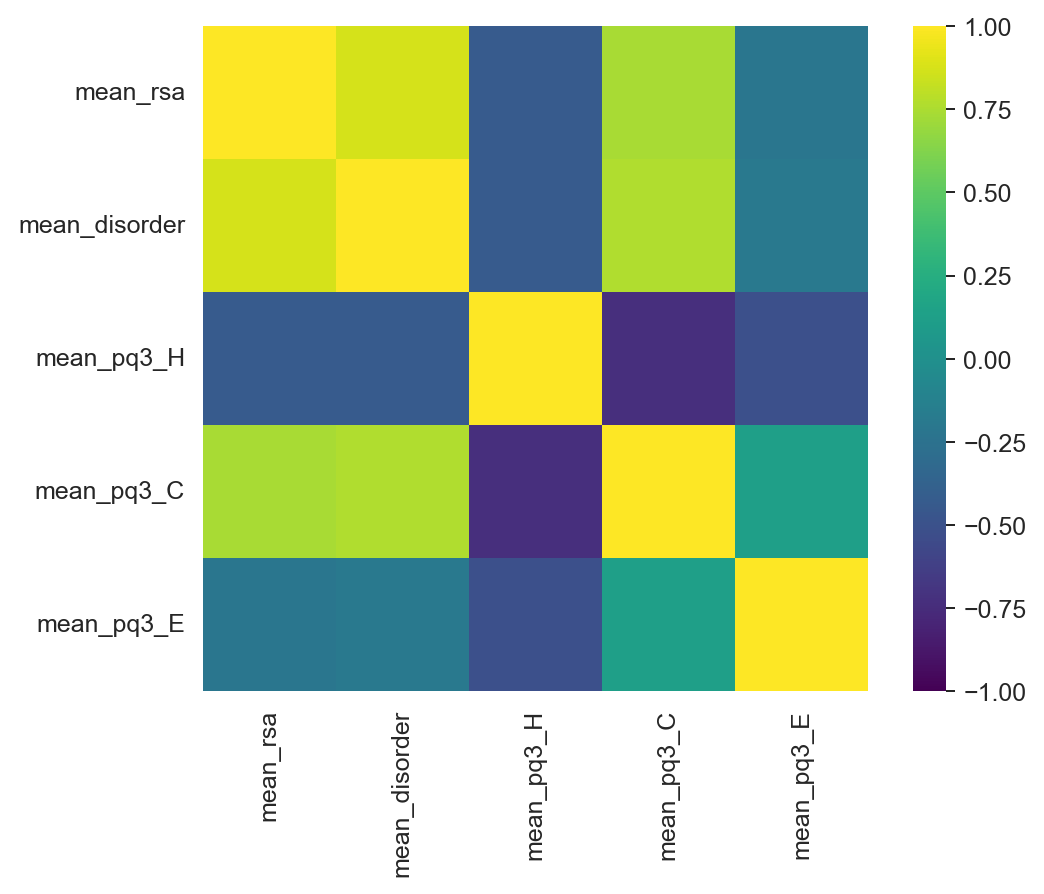

In [121]:
corr=no[['mean_rsa','mean_disorder','mean_pq3_H','mean_pq3_C','mean_pq3_E']].corr('spearman')
sns.heatmap(corr, square=True, cmap='viridis', vmin=-1, vmax=1, center=0, annot=False, annot_kws={'c':'k'})

In [14]:
corr

,mean_rsa,mean_disorder,mean_pq3_H,mean_pq3_C,mean_pq3_E
mean_rsa,1.000000,0.871292,-0.433379,0.737164,-0.213886
mean_disorder,0.871292,1.000000,-0.433125,0.763985,-0.188626
mean_pq3_H,-0.433379,-0.433125,1.000000,-0.733346,-0.514179
mean_pq3_C,0.737164,0.763985,-0.733346,1.000000,0.124389
mean_pq3_E,-0.213886,-0.188626,-0.514179,0.124389,1.000000


In [15]:
neg = add.query('label!=1')
pos = add.query('label==1')

In [16]:
from scipy.stats import ttest_ind

print('mean_disorder', ttest_ind(neg['mean_disorder'], pos['mean_disorder'], alternative='greater').pvalue)
print('mean_rsa', ttest_ind(neg['mean_rsa'], pos['mean_rsa'], alternative='greater').pvalue)
print('mean_pq3_H', ttest_ind(neg['mean_pq3_H'], pos['mean_pq3_H'], alternative='less').pvalue)
print('mean_pq3_E', ttest_ind(neg['mean_pq3_E'], pos['mean_pq3_E'], alternative='less').pvalue)
print('mean_pq3_C', ttest_ind(neg['mean_pq3_C'], pos['mean_pq3_C'], alternative='greater').pvalue)

mean_disorder 0.0
mean_rsa 0.0
mean_pq3_H 0.0
mean_pq3_E 7.532602681037607e-47
mean_pq3_C 0.0


In [17]:
no['indel'] = no['motif'].str.contains('-')
add['indel'] = add['motif'].str.contains('-')

In [18]:
no.groupby(['indel']).apply(lambda x: roc_auc_score(x['label'], x['pred']))

indel
False    0.985803
True     0.975748
dtype: float64

In [19]:
add.groupby(['indel']).apply(lambda x: roc_auc_score(x['label'], x['pred']))

indel
False    0.980782
True     0.967498
dtype: float64

In [123]:
add.groupby(['indel', 'label'])[mcs].mean()

mean_disorder  mean_rsa  mean_pq3_H  mean_pq3_C  mean_pq3_E
indel label                                                             
False 0.0         0.256442  0.397673    0.321557    0.547451    0.130992
      1.0         0.184044  0.359945    0.388841    0.468457    0.142702
True  0.0         0.260125  0.399092    0.319787    0.550768    0.129446
      1.0         0.165639  0.338595    0.411797    0.435759    0.152445

# other stuff

In [21]:
class Test(nn.Module):
    def __init__(self):
        super(Test, self).__init__()
        self.in_layer = nn.Linear(50,30)
        self.out_layer = nn.Linear(30, 1)
        self.dropout = nn.Dropout(0.25)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.get_logits(x)
        x = F.sigmoid(x)
        return x

    def get_logits(self, x):
        x = self.in_layer(x)
        x = self.dropout(x)
        x = self.act(x)
        x = self.out_layer(x)
        return x

In [24]:
mod = Test()
x = torch.rand(10, 50)
y = torch.randint(0, high=2, size=(1000,))

mod.train()
print(mod(x), mod.get_logits(x))

mod.eval()
print(mod(x), mod.get_logits(x))

tensor([[0.4910],
        [0.5063],
        [0.4697],
        [0.4541],
        [0.5470],
        [0.4423],
        [0.4870],
        [0.4644],
        [0.4530],
        [0.5029]], grad_fn=<SigmoidBackward0>) tensor([[-0.0719],
        [ 0.0114],
        [-0.0656],
        [ 0.0221],
        [-0.1686],
        [ 0.1238],
        [-0.1791],
        [-0.0342],
        [-0.1059],
        [-0.0020]], grad_fn=<AddmmBackward0>)
tensor([[0.4882],
        [0.4759],
        [0.5131],
        [0.4792],
        [0.4845],
        [0.4811],
        [0.4846],
        [0.4494],
        [0.4980],
        [0.5018]], grad_fn=<SigmoidBackward0>) tensor([[-0.0472],
        [-0.0965],
        [ 0.0524],
        [-0.0831],
        [-0.0619],
        [-0.0755],
        [-0.0615],
        [-0.2031],
        [-0.0082],
        [ 0.0071]], grad_fn=<AddmmBackward0>)


In [25]:
mod.train()
z = mod.get_logits(x)[:25]
mod.eval()
z2 = mod.get_logits(x)[:25]

# BNDOEL

In [26]:
cols = ['Peptide', '9mercore', 'Offset', 'Target', 'EL_rank', 'prediction', 'PeptideX', 'XX1', 'XX2', 'XX3', 'XX4', 'Icore', 'XX5', 'cell-lineID', 'HLA', 'XX6']

In [27]:
len(no['HLA'].unique())

138

In [28]:
bndo_no = pd.concat([pd.read_csv(x) for x in glob.glob('../output/2501XX_BNDOEL_MeanStructEval/*False*/*valid*.csv')])
bndo_add = pd.concat([pd.read_csv(x) for x in glob.glob('../output/2501XX_BNDOEL_MeanStructEval/*True*/*valid*.csv')])

In [29]:
bndo_no['indel'] = bndo_no['motif'].str.contains('-')
bndo_add['indel'] = bndo_add['motif'].str.contains('-')


In [30]:
display(no.groupby(['indel']).apply(lambda x: roc_auc_score(x['target'], x['pred'])))
display(add.groupby(['indel']).apply(lambda x: roc_auc_score(x['target'], x['pred'])))

indel
False    0.985803
True     0.975748
dtype: float64

indel
False    0.980782
True     0.967498
dtype: float64

In [31]:
display(bndo_no.groupby(['indel']).apply(lambda x: roc_auc_score(x['target'], x['pred'])))
display(bndo_add.groupby(['indel']).apply(lambda x: roc_auc_score(x['target'], x['pred'])))

indel
False    0.984827
True     0.973747
dtype: float64

indel
False    0.984447
True     0.972986
dtype: float64

In [32]:
print(roc_auc_score(no['target'], no['pred']))
print(roc_auc_score(add['target'], add['pred']))

0.98527552205173
0.980122336784646


In [33]:
print(roc_auc_score(bndo_no['target'], bndo_no['pred']))
print(roc_auc_score(bndo_add['target'], bndo_add['pred']))

0.9842425167779146
0.9838750632310868


Text(0.5, 1.0, 'Adding mean structure comparison\nValidation partition AUC (5 partitions merged)')

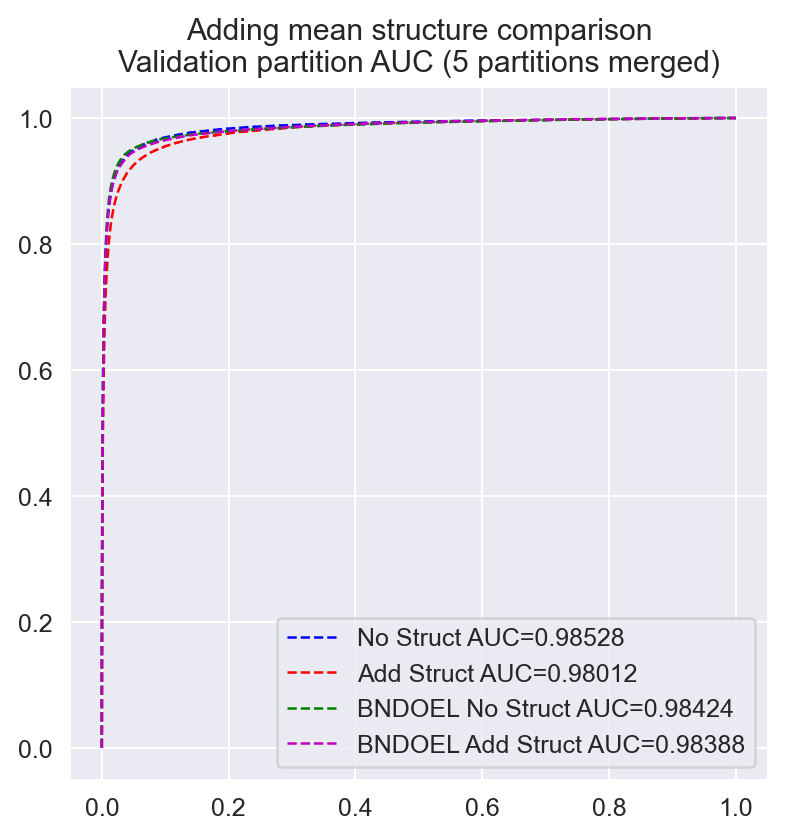

In [105]:
f,a = plt.subplots(1,1, figsize=(5,5))
fpr, tpr, _ = roc_curve(no_struct['target'], no_struct['pred'])
auc = roc_auc_score(no_struct['target'], no_struct['pred'])
a.plot(fpr, tpr, c='b', lw=1, ls='--', label=f'No Struct AUC={auc:.5f}')
fpr, tpr, _ = roc_curve(add_struct['target'], add_struct['pred'])
auc = roc_auc_score(add_struct['target'], add_struct['pred'])
a.plot(fpr, tpr, c='r', lw=1, ls='--', label=f'Add Struct AUC={auc:.5f}')

fpr, tpr, _ = roc_curve(bndo_no['target'], bndo_no['pred'])
auc = roc_auc_score(bndo_no['target'], bndo_no['pred'])
a.plot(fpr, tpr, c='g', lw=1, ls='--', label=f'BNDOEL No Struct AUC={auc:.5f}')

fpr, tpr, _ = roc_curve(bndo_add['target'], bndo_add['pred'])
auc = roc_auc_score(bndo_add['target'], bndo_add['pred'])
a.plot(fpr, tpr, c='m', lw=1, ls='--', label=f'BNDOEL Add Struct AUC={auc:.5f}')
a.legend()
a.set_title('Adding mean structure comparison\nValidation partition AUC (5 partitions merged)')

# per HLA

In [34]:
no['class']  = no['HLA'].apply(lambda x: x[:5])
add['class']  = add['HLA'].apply(lambda x: x[:5])
bndo_no['class']  = bndo_no['HLA'].apply(lambda x: x[:5])
bndo_add['class']  = bndo_add['HLA'].apply(lambda x: x[:5])


In [84]:
print('Per HLA Validation AUC (all partitions concatenated) (best epoch):')

print('#'*15, '\nNH64 - No Structure')
display(no.groupby('class').apply(lambda x: roc_auc_score(x['target'], x['pred'])))
print('Mean AUC: ', roc_auc_score(no['target'], no['pred']))
print('#'*15, '\nNH64 - With Mean Structure')
display(add.groupby('class').apply(lambda x: roc_auc_score(x['target'], x['pred'])))
print('Mean AUC: ', roc_auc_score(add['target'], add['pred']))
print('#'*15, '\nNH64-BatchNormDropOutExtraLayer - No Structure')
display(bndo_no.groupby('class').apply(lambda x: roc_auc_score(x['target'], x['pred'])))
print('Mean AUC: ', roc_auc_score(bndo_no['target'], bndo_no['pred']))
print('#'*15, '\nNH64-BatchNormDropOutExtraLayer - With Mean Structure')
display(bndo_add.groupby('class').apply(lambda x: roc_auc_score(x['target'], x['pred'])))
print('Mean AUC: ', roc_auc_score(bndo_add['target'], bndo_add['pred']))

Per HLA Validation AUC (all partitions concatenated) (best epoch):
############### 
NH64 - No Structure


class
HLA-A    0.979300
HLA-B    0.986941
HLA-C    0.981366
dtype: float64

Mean AUC:  0.98527552205173
############### 
NH64 - With Mean Structure


class
HLA-A    0.970997
HLA-B    0.981200
HLA-C    0.978694
dtype: float64

Mean AUC:  0.980122336784646
############### 
NH64-BatchNormDropOutExtraLayer - No Structure


class
HLA-A    0.978349
HLA-B    0.986978
HLA-C    0.979614
dtype: float64

Mean AUC:  0.9842425167779146
############### 
NH64-BatchNormDropOutExtraLayer - With Mean Structure


class
HLA-A    0.977061
HLA-B    0.985805
HLA-C    0.980521
dtype: float64

Mean AUC:  0.9838750632310868


In [37]:
ttest_ind(no.query('label==1')[mcs[0]], no.query('label!=1')[mcs[0]], equal_var=False)[1]

0.0

In [110]:
from statsmodels.stats.weightstats import ttest_ind as tt_ind

In [115]:
for c in mcs:
    print(c)
    pos_v = no.query('label==1')[c].values
    neg_v = no.query('label!=1')[c].values
    print('pos_mean', round(pos_v.mean(),5))
    print('neg_mean', round(neg_v.mean(),5))
    print('pv: ',tt_ind(pos_v, neg_v, usevar='unequal', )[1])

mean_disorder
pos_mean 0.18288
neg_mean 0.25705
pv:  0.0
mean_rsa
pos_mean 0.35859
neg_mean 0.39791
pv:  0.0
mean_pq3_H
pos_mean 0.39029
neg_mean 0.32126
pv:  0.0
mean_pq3_C
pos_mean 0.46639
neg_mean 0.548
pv:  0.0
mean_pq3_E
pos_mean 0.14332
neg_mean 0.13074
pv:  9.079952762980265e-41


In [38]:
for mc in mcs:
    print(mc)
    for hla in sorted(no['class'].unique()):
        pv = ttest_ind(no.query('`class`==@hla and label==1')[mc], no.query('`class`==@hla and label==0')[mc])[1]
        print(hla, pv)

mean_disorder
HLA-A 1.8239056092122013e-131
HLA-B 7.745352011086075e-246
HLA-C 7.546362795386301e-104
mean_rsa
HLA-A 1.4120709104214144e-216
HLA-B 0.0
HLA-C 1.5776569832732848e-218
mean_pq3_H
HLA-A 1.1097997675951084e-118
HLA-B 5.042818953259297e-217
HLA-C 2.7658993504017453e-74
mean_pq3_C
HLA-A 1.5326165760947417e-204
HLA-B 0.0
HLA-C 2.19650818992572e-139
mean_pq3_E
HLA-A 6.164227977996615e-12
HLA-B 2.378520330873473e-28
HLA-C 1.1459937245332344e-16


# ?

In [98]:
add.groupby(['indel', 'target'])[mcs].mean()

mean_disorder  mean_rsa  mean_pq3_H  mean_pq3_C  mean_pq3_E
indel target                                                             
False 0.0          0.256442  0.397673    0.321557    0.547451    0.130992
      1.0          0.184044  0.359945    0.388841    0.468457    0.142702
True  0.0          0.260125  0.399092    0.319787    0.550768    0.129446
      1.0          0.165639  0.338595    0.411797    0.435759    0.152445

# Redo benchmark  

In [40]:
%ls ../output/NNAlign_Benchmark

BaseModel_NH54_KFold_0_250115_1716_tg1tQ/
BaseModel_NH54_KFold_1_250115_1716_tg1tQ/
BaseModel_NH54_KFold_2_250115_1818_tg1tQ/
BaseModel_NH54_KFold_3_250115_2224_tg1tQ/
BaseModel_NH54_KFold_4_250115_2224_tg1tQ/
ExtendedModel_NH54BNDOEL27_KFold_0_250115_2326_aVmub/
ExtendedModel_NH54BNDOEL27_KFold_1_250116_0332_aVmub/
ExtendedModel_NH54BNDOEL27_KFold_2_250116_0332_aVmub/
ExtendedModel_NH54BNDOEL27_KFold_3_250116_0433_aVmub/
ExtendedModel_NH54BNDOEL27_KFold_4_250116_0231_aVmub/


In [45]:
base_files=sorted(glob.glob('../output/NNAlign_Benchmark/*Base*/*test*.csv'))
ext_files=sorted(glob.glob('../output/NNAlign_Benchmark/*Extended*/*test*.csv'))

In [53]:
base_test_preds = pd.concat([pd.read_csv(x, index_col=[0]).assign(k=i).reset_index() for i,x in enumerate(base_files)])
ext_test_preds = pd.concat([pd.read_csv(x, index_col=[0]).assign(k=i).reset_index() for i,x in enumerate(ext_files)])

In [66]:
base_mean_preds = base_test_preds.groupby(['sequence','9mercore','EL_rank','morni_pred','PeptideX','HLA'])[['pred', 'target']].mean().reset_index()
ext_mean_preds = ext_test_preds.groupby(['sequence','9mercore','EL_rank','morni_pred','PeptideX','HLA'])[['pred', 'target']].mean().reset_index()

In [72]:
base_mean_preds['class']=base_mean_preds['HLA'].apply(lambda x: x[:5])
ext_mean_preds['class']=ext_mean_preds['HLA'].apply(lambda x: x[:5])

In [82]:
display(base_mean_preds.groupby('class').apply(lambda x: roc_auc_score(x['target'].astype(int), x['pred'])))
display(ext_mean_preds.groupby('class').apply(lambda x: roc_auc_score(x['target'].astype(int), x['pred'])))

class
HLA-A    0.955733
HLA-B    0.973793
HLA-C    0.924621
dtype: float64

class
HLA-A    0.937703
HLA-B    0.970009
HLA-C    0.918552
dtype: float64

In [91]:
ext_mean_preds

,sequence,9mercore,EL_rank,morni_pred,PeptideX,HLA,pred,target,class
0,AAAAAAAAAAASG,AAAAAAAAG,87.550911,4.898000e-07,AAAAAAAAAAASG,HLA-B35:07,0.000387,0.0,HLA-B
1,AAAAAAAAAAASG,AAAAAAAAG,89.661476,6.770000e-08,AAAAAAAAAAASG,HLA-C07:01,0.000553,0.0,HLA-C
2,AAAAAAAAAAGG,AAAAAAAAG,68.797020,1.220300e-05,AAAAAAAAAAGG,HLA-B57:03,0.000276,1.0,HLA-B
3,AAAAAAAAAAGTF,AAAAAAATF,37.606213,8.285652e-04,AAAAAAAAAAGTF,HLA-A34:01,0.001651,0.0,HLA-A
4,AAAAAAAAAALQ,AAAAAAALQ,64.057755,6.376900e-06,AAAAAAAAAALQ,HLA-A74:01,0.000370,0.0,HLA-A
...,...,...,...,...,...,...,...,...,...
1398211,YYYYLPWAHT,YYYYLPWAT,52.146690,1.956530e-05,YYYYLPWAHT,HLA-A32:01,0.000130,0.0,HLA-A
1398212,YYYYMWKYIS,YYYYMWKYI,87.778130,4.444000e-07,YYYYMWKYIS,HLA-C02:02,0.000070,0.0,HLA-C
1398213,YYYYQVGRR,YYYYQVGRR,36.744293,1.463470e-04,YYYYQVGRR,HLA-B15:17,0.000264,0.0,HLA-B
1398214,YYYYYTLTEIILL,YTLTEIILL,54.903702,1.207700e-05,YYYYYTLTEIILL,HLA-A74:01,0.000046,0.0,HLA-A


In [93]:
roc_auc_score(ext_mean_preds['target'].astype(int), ext_mean_preds['pred'])

0.9518568123420876

In [94]:
roc_auc_score(base_mean_preds['target'].astype(int), base_mean_preds['pred'])

0.9588198137132186

In [95]:
roc_auc_score(base_mean_preds['target'].astype(int), base_mean_preds['morni_pred'])

0.9640407623289398

In [79]:
# take per HLA mean then overall mean instead of concat auc
base_mean_preds.groupby(['HLA']).apply(lambda x: roc_auc_score(x['target'].astype(int), x['morni_pred'])).mean()

0.9628638629011012

In [76]:
display(base_mean_preds.groupby('class').apply(lambda x: roc_auc_score(x['target'].astype(int), x['morni_pred'])))


class
HLA-A    0.969009
HLA-B    0.976756
HLA-C    0.922927
dtype: float64

# NH64 models

In [87]:
base_64_preds = pd.read_csv('../output/ensemble_1251_preds/ensemble_preds_Nh64_BaseModel_NoMeanStruct_KFold_-1_250116_1251_YuMNr/test_predictions_CONCAT_merged_test_sets_ligands_abelin_no_U_ensemble_preds_Nh64_BaseModel_NoMeanStruct_KFold_-1_250116_1251_YuMNr.csv').groupby(['sequence','9mercore','EL_rank','morni_pred','PeptideX','HLA'])[['pred', 'target']].mean().reset_index()
ext_64_preds = pd.read_csv('../output/ensemble_1251_preds/ensemble_preds_Nh64_BnDoEL_NoMeanStruct_KFold_-1_250116_1251_1UiHU/test_predictions_CONCAT_merged_test_sets_ligands_abelin_no_U_ensemble_preds_Nh64_BnDoEL_NoMeanStruct_KFold_-1_250116_1251_1UiHU.csv').groupby(['sequence','9mercore','EL_rank','morni_pred','PeptideX','HLA'])[['pred', 'target']].mean().reset_index()

In [89]:
print(roc_auc_score(base_64_preds['target'].astype(int), base_64_preds['pred']))
print(roc_auc_score(ext_64_preds['target'].astype(int), ext_64_preds['pred']))

0.9576655653316566
0.9543810336842722


# Do Linear regression

In [125]:
df = no

In [163]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
import numpy as np

preds = []
trues = []
best_models = []
for k in tqdm(range(5)):
    train_folds = [x for x in range(5) if x != k]
    # Splitting the dataset based on partition
    train_df = df[df['fold'].isin(train_folds)]
    test_df = df[df['fold'] == k]
    
    features = ['pred']+mcs
    target='target'
    
    X_train, y_train = train_df[features], train_df[target].values.ravel()
    X_test, y_test = test_df[features], test_df[target].values.ravel()
    
    # Create PredefinedSplit using 'fold' column (mapping folds 0,1,2,3 for CV)
    # Sklearn expects validation folds to be labeled as -1 for training and 0,1,2,3 for validation
    split_indices = train_df['fold'].values  # The fold numbers for training data
    split_indices = np.where(np.isin(split_indices, train_folds), split_indices, -1)  # Convert to -1 for training
    
    predefined_cv = PredefinedSplit(test_fold=split_indices)
    
    # Define Ridge regression model
    model = LogisticRegression(penalty='l2')
    
    # Define hyperparameter grid (e.g., tuning alpha for regularization strength)
    param_grid = {
        'C': np.logspace(-4, 3, 15)  # Exploring a wide range of regularization strengths
    }
    
    # Perform GridSearchCV with pre-defined cross-validation
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=predefined_cv,  # Use predefined split
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Evaluate the best model on the held-out test set (partition 4)

    best_model = grid_search.best_estimator_
    best_models.append(best_model)
    print(k)
    print(f"Best Alpha: {grid_search.best_params_['C']}")
    print(f"Optimal Weights: {best_model.coef_}")
    preds.append(best_model.predict_proba(X_test)[:, 1])
    trues.append(y_test)

  0%|          | 0/5 [00:00<?, ?it/s]

0
Best Alpha: 0.31622776601683794
Optimal Weights: [[ 9.15060559  0.22205468 -0.42626871  0.10866498 -0.29222432  0.18340317]]
1
Best Alpha: 0.1
Optimal Weights: [[ 9.04680405  0.19300308 -0.4662242   0.10973022 -0.27209393  0.16213711]]
2
Best Alpha: 0.1
Optimal Weights: [[ 9.04680824  0.19094691 -0.47174013  0.11313461 -0.26877397  0.15554472]]
3
Best Alpha: 0.1
Optimal Weights: [[ 9.082354    0.1932814  -0.46865087  0.11107713 -0.2659302   0.15526609]]
4
Best Alpha: 0.1
Optimal Weights: [[ 9.0328131   0.21258025 -0.47851008  0.07874299 -0.2869708   0.20773804]]


In [164]:
roc_auc_score(np.concatenate(trues), np.concatenate(preds))

0.978956106932535

In [182]:
mcs

['mean_disorder', 'mean_rsa', 'mean_pq3_H', 'mean_pq3_C', 'mean_pq3_E']

In [180]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
import numpy as np

preds = []
trues = []
best_models = []
for k in tqdm(range(5)):
    train_folds = [x for x in range(5) if x != k]
    # Splitting the dataset based on partition
    train_df = df[df['fold'].isin(train_folds)]
    test_df = df[df['fold'] == k]
    
    features = ['pred']+mcs
    target='target'
    
    X_train, y_train = train_df[features], train_df[target].values.ravel()
    X_test, y_test = test_df[features], test_df[target].values.ravel()
    
    # Create PredefinedSplit using 'fold' column (mapping folds 0,1,2,3 for CV)
    # Sklearn expects validation folds to be labeled as -1 for training and 0,1,2,3 for validation
    split_indices = train_df['fold'].values  # The fold numbers for training data
    split_indices = np.where(np.isin(split_indices, train_folds), split_indices, -1)  # Convert to -1 for training
    
    predefined_cv = PredefinedSplit(test_fold=split_indices)
    
    # Define Ridge regression model
    model = Ridge()
    
    # Define hyperparameter grid (e.g., tuning alpha for regularization strength)
    param_grid = {
        'alpha': np.logspace(-4, 3, 15)  # Exploring a wide range of regularization strengths
    }
    
    # Perform GridSearchCV with pre-defined cross-validation
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=predefined_cv,  # Use predefined split
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Evaluate the best model on the held-out test set (partition 4)

    best_model = grid_search.best_estimator_
    best_models.append(best_model)
    print(k)
    print(f"Best Alpha: {grid_search.best_params_['alpha']}")
    print(f"Optimal Weights: {[f'{x:.4f}' for x in best_model.coef_]}")
    preds.append(best_model.predict(X_test))
    trues.append(y_test)

print('Linear Model\nConcatenated AUC (held-out test set in nested crossvalidation)')
roc_auc_score(np.concatenate(trues), np.concatenate(preds))

  0%|          | 0/5 [00:00<?, ?it/s]

0
Best Alpha: 0.00031622776601683794
Optimal Weights: ['1.0157', '0.0029', '-0.0004', '0.0006', '-0.0024', '0.0014']
1
Best Alpha: 0.0001
Optimal Weights: ['1.0122', '0.0027', '-0.0012', '0.0005', '-0.0023', '0.0011']
2
Best Alpha: 0.00031622776601683794
Optimal Weights: ['1.0127', '0.0028', '-0.0017', '0.0029', '0.0003', '0.0034']
3
Best Alpha: 0.00031622776601683794
Optimal Weights: ['1.0141', '0.0027', '-0.0012', '0.0034', '0.0007', '0.0038']
4
Best Alpha: 0.001
Optimal Weights: ['1.0119', '0.0031', '-0.0012', '0.0005', '-0.0021', '0.0023']
Linear Model
Concatenated AUC (held-out test set in nested crossvalidation)


0.9845544656769816

In [181]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
import numpy as np

preds = []
trues = []
best_models = []
for k in tqdm(range(5)):
    train_folds = [x for x in range(5) if x != k]
    # Splitting the dataset based on partition
    train_df = df[df['fold'].isin(train_folds)]
    test_df = df[df['fold'] == k]
    
    features = mcs
    target='target'
    
    X_train, y_train = train_df[features], train_df[target].values.ravel()
    X_test, y_test = test_df[features], test_df[target].values.ravel()
    
    # Create PredefinedSplit using 'fold' column (mapping folds 0,1,2,3 for CV)
    # Sklearn expects validation folds to be labeled as -1 for training and 0,1,2,3 for validation
    split_indices = train_df['fold'].values  # The fold numbers for training data
    split_indices = np.where(np.isin(split_indices, train_folds), split_indices, -1)  # Convert to -1 for training
    
    predefined_cv = PredefinedSplit(test_fold=split_indices)
    
    # Define Ridge regression model
    model = Ridge()
    
    # Define hyperparameter grid (e.g., tuning alpha for regularization strength)
    param_grid = {
        'alpha': np.logspace(-4, 3, 15)  # Exploring a wide range of regularization strengths
    }
    
    # Perform GridSearchCV with pre-defined cross-validation
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=predefined_cv,  # Use predefined split
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Evaluate the best model on the held-out test set (partition 4)

    best_model = grid_search.best_estimator_
    best_models.append(best_model)
    print(k)
    print(f"Best Alpha: {grid_search.best_params_['alpha']}")
    print(f"Optimal Weights: {[f'{x:.4f}' for x in best_model.coef_]}")
    preds.append(best_model.predict(X_test))
    trues.append(y_test)

print('Linear Model\nConcatenated AUC (held-out test set in nested crossvalidation)')
roc_auc_score(np.concatenate(trues), np.concatenate(preds))

  0%|          | 0/5 [00:00<?, ?it/s]

0
Best Alpha: 0.01
Optimal Weights: ['0.0102', '-0.0618', '0.0115', '-0.0204', '0.0088']
1
Best Alpha: 0.00031622776601683794
Optimal Weights: ['0.0109', '-0.0613', '0.0110', '-0.0215', '0.0094']
2
Best Alpha: 0.0001
Optimal Weights: ['0.0102', '-0.0621', '0.0156', '-0.0158', '0.0128']
3
Best Alpha: 0.01
Optimal Weights: ['0.0100', '-0.0600', '0.0116', '-0.0204', '0.0089']
4
Best Alpha: 0.00031622776601683794
Optimal Weights: ['0.0112', '-0.0638', '0.0120', '-0.0205', '0.0108']
Linear Model
Concatenated AUC (held-out test set in nested crossvalidation)


0.580639295727528

In [174]:
roc_auc_score(df['target'], df['pred'])

0.98527552205173

In [ ]:
# lmplot of X = pred, Y = mean feature  
# do linear regression mean struct + pred
# -->  New Pred = w1 * pred + w2 * disorder + w3 * p_helix ...

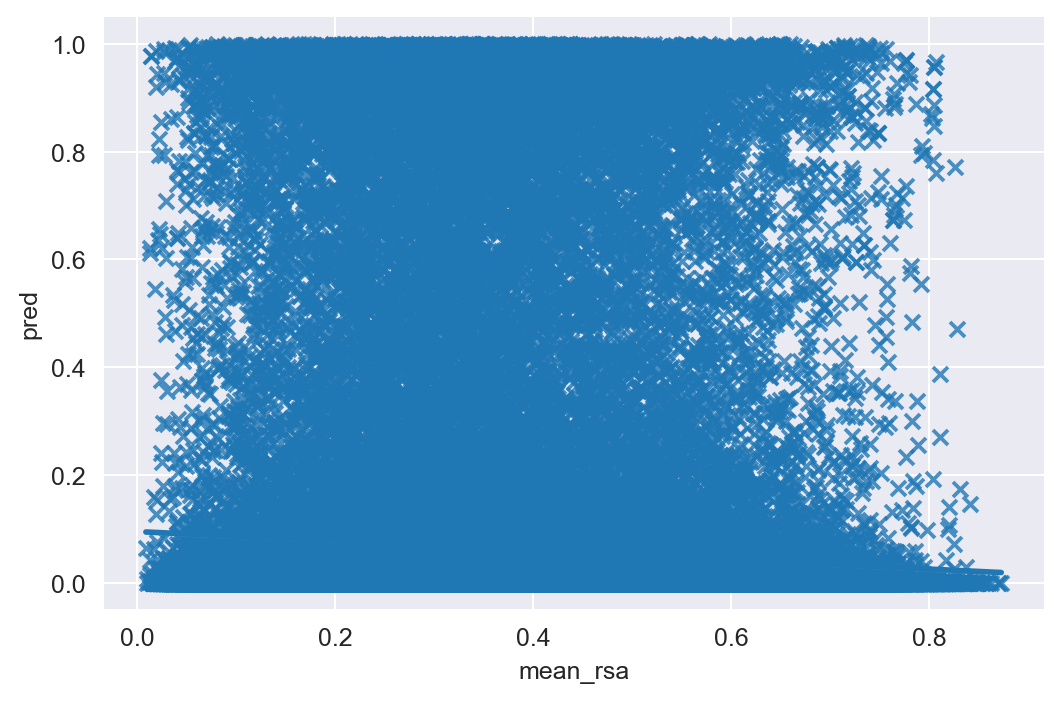

In [190]:
p0 = df.query('fold==0')
sns.lmplot(data=p0, x='mean_rsa', y='pred', height=4, aspect=1.5, fit_reg=True, markers='x')

# HLA DR

In [3]:
ls ../output/HLA_DR_Structure_Benchmark

HLA_DR_AddMeanStructure_KFold_0_250124_1502_ZSfVe/
HLA_DR_AddMeanStructure_KFold_1_250124_1358_ZSfVe/
HLA_DR_AddMeanStructure_KFold_2_250124_1856_ZSfVe/
HLA_DR_AddMeanStructure_KFold_3_250124_1357_ZSfVe/
HLA_DR_AddMeanStructure_KFold_4_250124_1358_ZSfVe/
HLA_DR_PerPositionStructure_KFold_0_250124_1358_xZ60H/
HLA_DR_PerPositionStructure_KFold_1_250124_1358_xZ60H/
HLA_DR_PerPositionStructure_KFold_2_250124_1358_xZ60H/
HLA_DR_PerPositionStructure_KFold_3_250124_1358_xZ60H/
HLA_DR_PerPositionStructure_KFold_4_250124_1358_xZ60H/
HLA_DR_baseline_KFold_0_250124_1357_fmBJB/
HLA_DR_baseline_KFold_1_250124_1839_fmBJB/
HLA_DR_baseline_KFold_2_250124_1357_fmBJB/
HLA_DR_baseline_KFold_3_250124_1357_fmBJB/
HLA_DR_baseline_KFold_4_250124_1436_fmBJB/


In [212]:
baseline_valid = sorted(glob.glob('../output/*HLA_DR*/*baseline*/*valid*.csv'))
baseline_test = sorted(glob.glob('../output/*HLA_DR*/*baseline*/*test*.csv'))
mean_str_valid = sorted(glob.glob('../output/*HLA_DR*/*AddMean*/*valid*.csv'))
mean_str_test = sorted(glob.glob('../output/*HLA_DR*/*AddMean*/*test*.csv'))
pos_str_valid = sorted(glob.glob('../output/*HLA_DR*/*PerPosition*/*valid*.csv'))
pos_str_test = sorted(glob.glob('../output/*HLA_DR*/*PerPosition*/*test*.csv'))

In [213]:
baseline_valid = pd.concat(pd.read_csv(x).assign(partition=i) for i,x in enumerate(baseline_valid))
baseline_test = pd.concat(pd.read_csv(x).assign(partition=i) for i,x in enumerate(baseline_test))
mean_str_valid = pd.concat(pd.read_csv(x).assign(partition=i) for i,x in enumerate(mean_str_valid))
mean_str_test = pd.concat(pd.read_csv(x).assign(partition=i) for i,x in enumerate(mean_str_test))
pos_str_valid = pd.concat(pd.read_csv(x).assign(partition=i) for i,x in enumerate(pos_str_valid))
pos_str_test = pd.concat(pd.read_csv(x).assign(partition=i) for i,x in enumerate(pos_str_test))

In [233]:
baseline_valid.drop(columns=['rsa','pq3_C','pq3_E','pq3_H', 'disorder'], inplace=True)
baseline_test.drop(columns=['rsa','pq3_C','pq3_E','pq3_H', 'disorder'], inplace=True)
mean_str_valid.drop(columns=['rsa','pq3_C','pq3_E','pq3_H', 'disorder'], inplace=True)
mean_str_test.drop(columns=['rsa','pq3_C','pq3_E','pq3_H', 'disorder'], inplace=True)
pos_str_valid.drop(columns=['rsa','pq3_C','pq3_E','pq3_H', 'disorder'], inplace=True)
pos_str_test.drop(columns=['rsa','pq3_C','pq3_E','pq3_H', 'disorder'], inplace=True)

In [214]:
baseline_valid.head()

,binding_core,target,rank_prediction,sequence,sample,MHC,mhc_reliability,Prot_ID,prot_seq_start,rsa,...,pq3_C,disorder,split,fold,len,pred,core_start_index,label,motif,partition
0,LSCAASGFT,0.0,40.032166,SLRLSCAASGFTF,Racle__3947_GA_DQP,DRB1_0101,0.50,P01766,36,"0.4947966337203979,0.0887040644884109,0.528257...",...,"0.6273801922798157,0.0333108901977539,0.029621...","0.0002493423235137,0.0004729559004772,0.000105...",9,0,13,0.000660,3,0.0,LSCAASGFT,0
1,IIALQPALH,0.0,7.504114,GNGTILWIIALQPALHRPM,Racle__TIL1,DRB1_0101,0.55,Q8NGJ8,49,"0.1132873073220253,0.1084680333733558,0.237050...",...,"0.0083361454308032,0.0063877506181597,0.003110...","0.0004530339210759,0.0003750175819732,0.000159...",7,0,19,0.151239,7,0.0,IIALQPALH,0
2,HLVQNPVRL,0.0,26.738098,KQHLVQNPVRLWQL,Abelin__MAPTAC_DRB1_0101,DRB1_0101,1.00,Q9UQ90,81,"0.4836790859699249,0.510635256767273,0.3998480...",...,"0.6649949550628662,0.6861651539802551,0.776623...","0.4707789123058319,0.4287213683128357,0.462108...",1,0,14,0.007980,2,0.0,HLVQNPVRL,0
3,FMKGQPVSD,0.0,37.118717,KHFMKGQPVSDA,Nanaware__WT_1,DRB1_0101,0.55,Q5VV42,484,"0.670161783695221,0.4451413154602051,0.2888799...",...,"0.9574967622756958,0.966753363609314,0.5322399...","0.0345452353358268,0.0231256149709224,0.018548...",0,0,12,0.001831,22,0.0,KHFMKGQPV,0
4,VESKYGPPC,0.0,30.190418,DKRVESKYGPPC,Racle__3947_GA_DR,DRB1_0101,0.50,P01861,95,"0.6071872711181641,0.3440525233745575,0.617678...",...,"0.0519124828279018,0.0151984617114067,0.023349...","0.0008238095906563,0.0007368521764874,0.001177...",6,0,12,0.000814,3,0.0,VESKYGPPC,0


In [231]:
print('Valid')
print('C NNalign', round(roc_auc_score(baseline_valid['target'], 1-baseline_valid['rank_prediction']),5), round(roc_auc_score(baseline_valid['target'], 1-baseline_valid['rank_prediction'], max_fpr=0.1),5))
print('Baseline', round(roc_auc_score(baseline_valid['target'], baseline_valid['pred']),5), round(roc_auc_score(baseline_valid['target'], baseline_valid['pred'], max_fpr=0.1),5))
print('MeanStr', round(roc_auc_score(mean_str_valid['target'], mean_str_valid['pred']),5), round(roc_auc_score(mean_str_valid['target'], mean_str_valid['pred'], max_fpr=0.1),5))
print('PerPosStr', round(roc_auc_score(pos_str_valid['target'], pos_str_valid['pred']),5), round(roc_auc_score(pos_str_valid['target'], pos_str_valid['pred'], max_fpr=0.1),5))
print('test')
print('C NNalign', round(roc_auc_score(baseline_test['target'], 1-baseline_test['rank_prediction']),5), round(roc_auc_score(baseline_test['target'], 1-baseline_test['rank_prediction'], max_fpr=0.1),5))
print('Baseline', round(roc_auc_score(baseline_test['target'], baseline_test['pred']),5), round(roc_auc_score(baseline_test['target'], baseline_test['pred'], max_fpr=0.1),5))
print('MeanStr', round(roc_auc_score(mean_str_test['target'], mean_str_test['pred']),5), round(roc_auc_score(mean_str_test['target'], mean_str_test['pred'], max_fpr=0.1),5))
print('PerPosStr', round(roc_auc_score(pos_str_test['target'], pos_str_test['pred']),5), round(roc_auc_score(pos_str_test['target'], pos_str_test['pred'], max_fpr=0.1),5))

Valid
C NNalign 0.93239 0.84054
Baseline 0.9331 0.84372
MeanStr 0.90654 0.78759
PerPosStr 0.93563 0.84944
test
C NNalign 0.92399 0.82755
Baseline 0.92997 0.84855
MeanStr 0.90329 0.78765
PerPosStr 0.93244 0.85308


In [222]:
baseline_valid.groupby(['partition']).apply(lambda x: roc_auc_score(x['target'], x['pred']))

partition
0    0.931617
1    0.937809
2    0.935383
3    0.932056
4    0.929755
dtype: float64

In [221]:
pos_str_valid.groupby(['partition']).apply(lambda x: roc_auc_score(x['target'], x['pred']))

partition
0    0.934444
1    0.940279
2    0.938055
3    0.933906
4    0.932385
dtype: float64

In [228]:
mean_str_valid.groupby(['partition']).apply(lambda x: roc_auc_score(x['target'], x['pred']))

partition
0    0.879576
1    0.937337
2    0.934835
3    0.882870
4    0.885165
dtype: float64

In [224]:
baseline_test.groupby(['partition']).apply(lambda x: roc_auc_score(x['target'], x['pred']))

partition
0    0.928338
1    0.931602
2    0.930694
3    0.931241
4    0.928621
dtype: float64

In [225]:
mean_str_test.groupby(['partition']).apply(lambda x: roc_auc_score(x['target'], x['pred']))

partition
0    0.872853
1    0.930451
2    0.930404
3    0.885144
4    0.883343
dtype: float64

In [223]:
pos_str_test.groupby(['partition']).apply(lambda x: roc_auc_score(x['target'], x['pred']))

partition
0    0.931878
1    0.934213
2    0.932892
3    0.932653
4    0.931903
dtype: float64

In [229]:
len(baseline_valid)

922825

In [219]:
# print('Valid')
print('Baseline', round(roc_auc_score(baseline_valid['target'], 1-baseline_valid['rank_prediction']),5))
print('MeanStr', round(roc_auc_score(mean_str_valid['target'], 1-mean_str_valid['rank_prediction']),5))
print('PerPosStr', round(roc_auc_score(pos_str_valid['target'], 1-pos_str_valid['rank_prediction']),5))
print('test')
print('Baseline', round(roc_auc_score(baseline_test['target'], 1-baseline_test['rank_prediction']),5))
print('MeanStr', round(roc_auc_score(mean_str_test['target'], 1-mean_str_test['rank_prediction']),5))
print('PerPosStr', round(roc_auc_score(pos_str_test['target'], 1-pos_str_test['rank_prediction']),5))

Valid
Baseline 0.93239
MeanStr 0.93239
PerPosStr 0.93239
test
Baseline 0.92399
MeanStr 0.92399
PerPosStr 0.92399


In [234]:
pos_str_test

,Unnamed: 0.1,binding_core,target,sequence,MHC,Prot_ID,sample,fold,split,Unnamed: 0,rank_prediction,mhc_reliability,prot_seq_start,len,pred,core_start_index,label,motif,partition
0,438169,IERMVNDAE,1.0,TPEEIERMVNDAEKFA,DRB1_0405,P11021,Abelin__HLA_DR_A375,2,4,3953,0.293091,0.65,534,16,0.793491,4,1.0,IERMVNDAE,0
1,610523,ITEYRASHS,0.0,KEYLVNITEYRASHSTP,DRB1_1501,P0CW00,Racle__TIL3,0,4,91034,0.293137,0.85,218,17,0.750358,6,0.0,ITEYRASHS,0
2,454762,IGLNSLQKY,0.0,DADIGLNSLQKYKLSLN,DRB4_0103,Q9Y5G0,Saghar_9075_DR,2,9,16103,14.303994,0.45,159,17,0.012348,5,0.0,LNSLQKYKL,0
3,380180,HCFFQPREL,0.0,ALHCFFQPRELS,DRB1_0701,Q9UMW8,Racle__3808_HMC_DR,2,6,44246,67.679199,0.20,212,12,0.000183,2,0.0,HCFFQPREL,0
4,378575,GVSLAALKK,1.0,ERSGVSLAALKK,DRB1_1104,P16403,Khoda__MCL005,4,8,5115,52.091736,0.60,53,12,0.000025,3,1.0,GVSLAALKK,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188119,1286423,RNHESALQL,0.0,FKLPRNHESALQLGL,DRB1_0701,Q8NEG5,Khoda__L128,2,1,61068,49.623569,0.55,87,15,0.000251,6,0.0,HESALQLGL,4
188120,1365611,VDKVIMKLG,0.0,HVDKVIMKLGKT,DRB1_0701,Q8TCX1,Abelin__MAPTAC_DRB1_0701,4,5,19617,93.021988,1.00,137,12,0.000026,1,0.0,VDKVIMKLG,4
188121,49840,CRRQSSNSC,0.0,CRSHRCRRQSSNSCD,DRB1_0901,Q5TA77,Abelin__MAPTAC_DRB1_0901,0,4,57717,99.467888,1.00,61,15,0.000032,6,0.0,RRQSSNSCD,4
188122,1788735,YTNCYAQRY,0.0,MSPYTNCYAQRYYPMPEEP,DRB1_0103,Q96KJ9,Racle__3869_GA,0,3,103019,55.418228,0.55,34,19,0.000178,7,0.0,YAQRYYPMP,4


In [23]:
t200_baseline = pd.read_csv('../output/250127_HLADR_ensemble_preds/HLA_DR_ensemble_preds_baseline_200k_testset_KFold_-1_250127_1638_Oseqf/test_predictions_CONCAT_HLA_DR_notsampled_200k_selected_test_set_HLA_DR_ensemble_preds_baseline_200k_testset_KFold_-1_250127_1638_Oseqf.csv',
                           usecols=['sequence','target','MHC','sample','fold', 'sample', 'Prot_ID','rank_prediction', 'pred', 'motif', 'model_n'])
t200_meanstr = pd.read_csv('../output/250127_HLADR_ensemble_preds/HLA_DR_ensemble_preds_MeanStruct_200k_testset_KFold_-1_250127_1739_2mOUk/test_predictions_CONCAT_HLA_DR_notsampled_200k_selected_test_set_HLA_DR_ensemble_preds_MeanStruct_200k_testset_KFold_-1_250127_1739_2mOUk.csv',
                          usecols=['sequence','target','MHC','sample','fold', 'sample', 'Prot_ID', 'rank_prediction', 'pred', 'motif', 'model_n'])
t200_posstr = pd.read_csv('../output/250127_HLADR_ensemble_preds/HLA_DR_ensemble_preds_PerPosStruct_200k_testset_KFold_-1_250127_2058_hEPOL/test_predictions_CONCAT_HLA_DR_notsampled_200k_selected_test_set_HLA_DR_ensemble_preds_PerPosStruct_200k_testset_KFold_-1_250127_2058_hEPOL.csv',
                         usecols=['sequence','target','MHC','sample','fold', 'sample', 'Prot_ID', 'rank_prediction', 'pred', 'motif', 'model_n'])


In [ ]:
0.9423505635013518

In [24]:
roc_auc_score(t200_meanstr['target'], t200_meanstr['pred'])

0.9423505635013518

In [19]:
def mean_pred(df):
    return df.groupby(['model_n', 'rank_prediction', 'sample', 'sequence', 'MHC', 'Prot_ID', 'sample'])[['target','pred']].mean()

x = mean_pred(t200_baseline)
print(roc_auc_score(x['target'].astype(int), x['pred']))

x = mean_pred(t200_meanstr)
print(roc_auc_score(x['target'].astype(int), x['pred']))

x = mean_pred(t200_posstr)
print(roc_auc_score(x['target'].astype(int), x['pred']))

0.9423447884570146
0.9423447884570146
0.9445888095240229


In [9]:
t200_baseline.groupby(['model_n','sequence','MHC','sample', 'Prot_ID'])[['target', 'pred']].mean()
t200_meanstr.groupby(['model_n','sequence','MHC','sample', 'Prot_ID'])[['target', 'pred']].mean()
t200_posstr.groupby(['model_n','sequence','MHC','sample', 'Prot_ID'])[['target', 'pred']].mean()

target      pred
model_n sequence              MHC                        
0       AAAAAAAAAAAAAGE       DRB1_1101     0.0  0.001953
        AAAAAAAAAAAGGGCGSGP   DRB1_0701     0.0  0.000105
        AAAAAAAAAAKV          DRB1_1303     0.0  0.000759
        AAAAAAAAAARCKAAEAAADE DRB1_0101     0.0  0.000619
        AAAAAAAAAGVPVGPEYG    DRB1_0701     0.0  0.004794
...                                         ...       ...
4       YYYNKRILHKTKGKRFTYKFN DRB1_1104     0.0  0.004271
        YYYNSSTCKKGKVFPGKISVT DRB5_0101     0.0  0.005336
        YYYRPARTGIISL         DRB1_0701     0.0  0.400188
        YYYTVTPNYDDFSVNF      DRB1_0101     0.0  0.001979
        YYYYTLTEIILLSVMAYDH   DRB1_0701     0.0  0.001402

[993605 rows x 2 columns]

In [ ]:
t500_baseline = pd.read_csv('../output/250127_HLADR_ensemble_preds/HLA_DR_ensemble_preds_baseline_500k_unseen_testset_KFold_-1_250127_1640_EMpqy/test_predictions_CONCAT_HLA_DR_500K_unseen_sequence_test_set_HLA_DR_ensemble_preds_baseline_500k_unseen_testset_KFold_-1_250127_1640_EMpqy.csv',
                            ['sequence','target','MHC','sample','fold', 'rank_prediction', 'pred', 'motif', 'model_n'])
t500_meanstr = pd.read_csv('../output/250127_HLADR_ensemble_preds/HLA_DR_ensemble_preds_MeanStruct_500k_unseen_testset_KFold_-1_250127_1843_1oQj5/test_predictions_CONCAT_HLA_DR_500K_unseen_sequence_test_set_HLA_DR_ensemble_preds_MeanStruct_500k_unseen_testset_KFold_-1_250127_1843_1oQj5.csv',
                           ['sequence','target','MHC','sample','fold', 'rank_prediction', 'pred', 'motif', 'model_n'])
t500_posstr = pd.read_csv('../output/250127_HLADR_ensemble_preds/HLA_DR_ensemble_preds_PerPosStruct_500k_unseen_testset_KFold_-1_250127_2058_axrmR/test_predictions_CONCAT_HLA_DR_500K_unseen_sequence_test_set_HLA_DR_ensemble_preds_PerPosStruct_500k_unseen_testset_KFold_-1_250127_2058_axrmR.csv',
                          ['sequence','target','MHC','sample','fold', 'rank_prediction', 'pred', 'motif', 'model_n'])